## Setup

In [1]:
# Install dependencies
!pip install -q numpy pandas matplotlib seaborn scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from typing import Set

sns.set_style('whitegrid')
print("✅ Setup complete!")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Setup complete!


## Configuration (Optimized for Speed)

In [2]:
CONFIG = {
    'budgets': [500, 2500, 5000],  # 3 budgets (vs 5)
    'n_trials': 30,  # 30 trials (vs 100)
    'algorithms': ['mc', 'ops', 'ops_cv'],  # 3 algorithms (skip PS, Neyman)
    'random_seed': 42,
}

np.random.seed(CONFIG['random_seed'])

print("⚡ QUICK TEST CONFIGURATION")
print(f"   Budgets: {CONFIG['budgets']}")
print(f"   Trials: {CONFIG['n_trials']}")
print(f"   Algorithms: {CONFIG['algorithms']}")
print(f"   Expected time: 25-35 minutes")

⚡ QUICK TEST CONFIGURATION
   Budgets: [500, 2500, 5000]
   Trials: 30
   Algorithms: ['mc', 'ops', 'ops_cv']
   Expected time: 25-35 minutes


## Algorithm Implementations

In [3]:
class ShapleyEstimator:
    """Monte Carlo baseline"""
    def __init__(self, game_function, n_features):
        self.game = game_function
        self.n = n_features
        self.N = set(range(n_features))
    
    def mc_shapley(self, feature_idx, n_samples, seed=None):
        if seed is not None:
            np.random.seed(seed)
        
        estimates = []
        N_minus_i = self.N - {feature_idx}
        
        for _ in range(n_samples):
            perm = list(np.random.permutation(list(N_minus_i)))
            k = np.random.randint(0, self.n)
            S = set(perm[:k])
            marginal = self.game(S | {feature_idx}) - self.game(S)
            estimates.append(marginal)
        
        return np.mean(estimates)


class OPSAntitheticShapley:
    """OPS with antithetic coupling"""
    def __init__(self, game_function, n_features):
        self.game = game_function
        self.n = n_features
        self.N = set(range(n_features))
    
    def compute(self, feature_idx, budget, seed=None):
        if seed is not None:
            np.random.seed(seed)
        
        N_minus_i = self.N - {feature_idx}
        samples_per_stratum = budget // self.n
        
        stratum_means = []
        for k in range(self.n):
            samples = []
            for _ in range(samples_per_stratum // 2):
                if k == 0:
                    S = set()
                elif k == self.n - 1:
                    S = N_minus_i
                else:
                    S = set(np.random.choice(list(N_minus_i), size=k, replace=False))
                
                T = N_minus_i - S
                marginal_S = self.game(S | {feature_idx}) - self.game(S)
                marginal_T = self.game(T | {feature_idx}) - self.game(T)
                samples.append((marginal_S + marginal_T) / 2)
            
            stratum_means.append(np.mean(samples))
        
        return np.mean(stratum_means)


class OPSControlVariatesShapley:
    """OPS-CV with linear surrogate"""
    def __init__(self, game_function, n_features):
        self.game = game_function
        self.n = n_features
        self.N = set(range(n_features))
        self._compute_linear_surrogate()
    
    def _compute_linear_surrogate(self):
        self.gradients = np.zeros(self.n)
        for i in range(self.n):
            self.gradients[i] = self.game({i}) - self.game(set())
    
    def _linear_game(self, S):
        if len(S) == 0:
            return 0.0
        return sum(self.gradients[i] for i in S)
    
    def compute(self, feature_idx, budget, seed=None):
        if seed is not None:
            np.random.seed(seed)
        
        estimator_v = OPSAntitheticShapley(self.game, self.n)
        phi_v = estimator_v.compute(feature_idx, budget, seed=seed)
        
        estimator_g = OPSAntitheticShapley(self._linear_game, self.n)
        phi_g = estimator_g.compute(feature_idx, budget, seed=seed)
        
        phi_g_exact = self.gradients[feature_idx]
        phi_cv = phi_v - 1.0 * (phi_g - phi_g_exact)
        
        return phi_cv

print("✅ Algorithm classes defined")

✅ Algorithm classes defined


## Generate Cooperative Games

In [4]:
def generate_games():
    """Generate 3 key submodular games"""
    games = {}
    np.random.seed(42)
    
    print("\n" + "="*70)
    print("GENERATING SUBMODULAR GAMES")
    print("="*70)
    
    # 1. Coverage Game (n=10) - Target: 9.7×
    print("\n1. Coverage Game (n=10)...")
    n = 10
    m = 30
    coverage_sets = [set(np.random.choice(m, size=np.random.randint(5, 12), replace=False)) 
                     for _ in range(n)]
    
    def coverage(S):
        if len(S) == 0:
            return 0.0
        covered = set()
        for i in S:
            covered |= coverage_sets[i]
        return float(len(covered))
    
    games['coverage_n10'] = {
        'game_function': coverage,
        'n_features': n,
        'target_vrf': 9.7,
        'description': f'Coverage: {n} players, {m} elements'
    }
    print(f"   ✅ n={n}, Target VRF: 9.7×")
    
    # 2. Facility Location (n=20) - Target: 22.8×
    print("\n2. Facility Location (n=20)...")
    n = 20
    locations = np.random.rand(n, 2) * 100
    customers = np.random.rand(50, 2) * 100
    
    def facility_location(S):
        if len(S) == 0:
            return 0.0
        served = 0
        for customer in customers:
            for facility_idx in S:
                dist = np.linalg.norm(customer - locations[facility_idx])
                if dist < 30:
                    served += 1
                    break
        return float(served)
    
    games['facility_n20'] = {
        'game_function': facility_location,
        'n_features': n,
        'target_vrf': 22.8,
        'description': f'Facility location: {n} facilities, 50 customers'
    }
    print(f"   ✅ n={n}, Target VRF: 22.8×")
    
    # 3. Random Submodular (n=50) - Target: 42.3× (OPS), 67.2× (OPS-CV)
    print("\n3. Random Submodular (n=50)...")
    n = 50
    base_values_50 = np.random.exponential(20, n)
    
    def random_submodular_50(S):
        if len(S) == 0:
            return 0.0
        sorted_S = sorted(S, key=lambda i: base_values_50[i], reverse=True)
        value = sum(base_values_50[i] / (1 + 0.25 * idx) for idx, i in enumerate(sorted_S))
        return value
    
    games['random_sub_n50'] = {
        'game_function': random_submodular_50,
        'n_features': n,
        'target_vrf': 42.3,
        'target_vrf_cv': 67.2,
        'description': f'Random submodular: {n} players (CRITICAL TEST)'
    }
    print(f"   ✅ n={n}, Target VRF: 42.3× (OPS), 67.2× (OPS-CV)")
    
    print("\n" + "="*70)
    print(f"✅ Generated {len(games)} games")
    print("="*70)
    
    return games

GAMES = generate_games()


GENERATING SUBMODULAR GAMES

1. Coverage Game (n=10)...
   ✅ n=10, Target VRF: 9.7×

2. Facility Location (n=20)...
   ✅ n=20, Target VRF: 22.8×

3. Random Submodular (n=50)...
   ✅ n=50, Target VRF: 42.3× (OPS), 67.2× (OPS-CV)

✅ Generated 3 games


## Run Quick Experiments

In [5]:
def run_quick_experiments(games, config):
    """Run fast validation experiments"""
    results = []
    
    budgets = config['budgets']
    n_trials = config['n_trials']
    algorithms = config['algorithms']
    
    total_experiments = len(games) * len(budgets) * len(algorithms) * n_trials
    
    print("\n" + "="*70)
    print("RUNNING QUICK VALIDATION EXPERIMENTS")
    print("="*70)
    print(f"\n📊 Configuration:")
    print(f"   Games: {len(games)}")
    print(f"   Budgets: {budgets}")
    print(f"   Algorithms: {algorithms}")
    print(f"   Trials: {n_trials}")
    print(f"   Total experiments: {total_experiments}")
    print(f"   Estimated time: 25-35 minutes\n")
    print("="*70)
    
    start_time = time.time()
    completed = 0
    
    for game_idx, (game_name, game_data) in enumerate(games.items(), 1):
        game_function = game_data['game_function']
        n_features = game_data['n_features']
        
        print(f"\n[{game_idx}/{len(games)}] {game_name} (n={n_features})")
        print(f"   {game_data['description']}")
        print("-"*70)
        
        feature_idx = 0  # Test only first feature
        
        for budget in budgets:
            print(f"\n  Budget {budget:5d}:", end=' ')
            budget_start = time.time()
            
            for algo in algorithms:
                algo_estimates = []
                
                for trial in range(n_trials):
                    seed = config['random_seed'] + trial
                    
                    if algo == 'mc':
                        estimator = ShapleyEstimator(game_function, n_features)
                        estimate = estimator.mc_shapley(feature_idx, budget, seed=seed)
                    elif algo == 'ops':
                        estimator = OPSAntitheticShapley(game_function, n_features)
                        estimate = estimator.compute(feature_idx, budget, seed=seed)
                    elif algo == 'ops_cv':
                        estimator = OPSControlVariatesShapley(game_function, n_features)
                        estimate = estimator.compute(feature_idx, budget, seed=seed)
                    
                    algo_estimates.append(estimate)
                    completed += 1
                
                empirical_variance = np.var(algo_estimates, ddof=1)
                
                results.append({
                    'game': game_name,
                    'n_features': n_features,
                    'budget': budget,
                    'algorithm': algo,
                    'mean_estimate': np.mean(algo_estimates),
                    'empirical_variance': empirical_variance,
                    'n_trials': n_trials
                })
            
            budget_time = time.time() - budget_start
            print(f"({budget_time:.1f}s)", end=' ')
            print(f"[{algo.upper()}]")
        
        elapsed = time.time() - start_time
        progress = (completed / total_experiments) * 100
        remaining = (elapsed / completed) * (total_experiments - completed) if completed > 0 else 0
        print(f"\n  Progress: {progress:.1f}% | Elapsed: {elapsed/60:.1f}m | Remaining: {remaining/60:.1f}m")
    
    total_time = time.time() - start_time
    print("\n" + "="*70)
    print(f"✅ EXPERIMENTS COMPLETE in {total_time/60:.1f} minutes")
    print("="*70)
    
    return pd.DataFrame(results)

RESULTS = run_quick_experiments(GAMES, CONFIG)


RUNNING QUICK VALIDATION EXPERIMENTS

📊 Configuration:
   Games: 3
   Budgets: [500, 2500, 5000]
   Algorithms: ['mc', 'ops', 'ops_cv']
   Trials: 30
   Total experiments: 810
   Estimated time: 25-35 minutes


[1/3] coverage_n10 (n=10)
   Coverage: 10 players, 30 elements
----------------------------------------------------------------------

  Budget   500: (0.4s) [OPS_CV]

  Budget  2500: (1.7s) [OPS_CV]

  Budget  5000: (3.4s) [OPS_CV]

  Progress: 33.3% | Elapsed: 0.1m | Remaining: 0.2m

[2/3] facility_n20 (n=20)
   Facility location: 20 facilities, 50 customers
----------------------------------------------------------------------

  Budget   500: (51.4s) [OPS_CV]

  Budget  2500: (743.4s) [OPS_CV]

  Budget  5000: (492.0s) [OPS_CV]

  Progress: 66.7% | Elapsed: 21.5m | Remaining: 10.8m

[3/3] random_sub_n50 (n=50)
   Random submodular: 50 players (CRITICAL TEST)
----------------------------------------------------------------------

  Budget   500: (1.3s) [OPS_CV]

  Budget  25

## Compute Variance Reduction Factors

In [6]:
def compute_vrf(results_df):
    """Compute variance reduction factors"""
    vrf_results = []
    
    for game in results_df['game'].unique():
        game_data = results_df[results_df['game'] == game]
        n = game_data['n_features'].iloc[0]
        
        # Get MC variance (baseline) across all budgets
        mc_data = game_data[game_data['algorithm'] == 'mc']
        mc_variance_mean = mc_data['empirical_variance'].mean()
        
        for algo in ['ops', 'ops_cv']:
            algo_data = game_data[game_data['algorithm'] == algo]
            algo_variance_mean = algo_data['empirical_variance'].mean()
            
            vrf = mc_variance_mean / algo_variance_mean if algo_variance_mean > 0 else 1.0
            
            vrf_results.append({
                'game': game,
                'n_features': n,
                'algorithm': algo,
                'vrf': vrf,
                'mc_variance': mc_variance_mean,
                'algo_variance': algo_variance_mean
            })
    
    return pd.DataFrame(vrf_results)

VRF_DF = compute_vrf(RESULTS)

print("\n" + "="*70)
print("VARIANCE REDUCTION FACTORS")
print("="*70)
print("\n" + VRF_DF.to_string(index=False))
print("\n" + "="*70)


VARIANCE REDUCTION FACTORS

          game  n_features algorithm       vrf  mc_variance  algo_variance
  coverage_n10          10       ops 11.704213     0.008617       0.000736
  coverage_n10          10    ops_cv 11.704213     0.008617       0.000736
  facility_n20          20       ops 26.234971     0.001588       0.000061
  facility_n20          20    ops_cv 26.234971     0.001588       0.000061
random_sub_n50          50       ops 55.511489     0.036198       0.000652
random_sub_n50          50    ops_cv 55.511489     0.036198       0.000652



## Summary & Comparison to Paper

In [7]:
# Create summary table
summary_data = []

for game in VRF_DF['game'].unique():
    game_vrf = VRF_DF[VRF_DF['game'] == game]
    n = game_vrf['n_features'].iloc[0]
    
    ops_vrf = game_vrf[game_vrf['algorithm'] == 'ops']['vrf'].values[0]
    ops_cv_vrf = game_vrf[game_vrf['algorithm'] == 'ops_cv']['vrf'].values[0]
    
    # Get paper targets
    game_info = GAMES[game]
    target_vrf = game_info.get('target_vrf', 0)
    target_vrf_cv = game_info.get('target_vrf_cv', 0)
    
    summary_data.append({
        'Game': game,
        'n': n,
        'OPS (Achieved)': f"{ops_vrf:.1f}×",
        'OPS (Target)': f"{target_vrf:.1f}×",
        'OPS-CV (Achieved)': f"{ops_cv_vrf:.1f}×",
        'OPS-CV (Target)': f"{target_vrf_cv:.1f}×" if target_vrf_cv > 0 else "N/A"
    })

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*70)
print("📊 QUICK TEST SUMMARY: ACHIEVED vs PAPER TARGETS")
print("="*70)
print("\n" + summary_df.to_string(index=False))

# Calculate achievement percentage
print("\n" + "="*70)
print("✅ VALIDATION STATUS")
print("="*70)

for _, row in summary_df.iterrows():
    n = row['n']
    ops_achieved = float(row['OPS (Achieved)'].replace('×', ''))
    ops_target = float(row['OPS (Target)'].replace('×', ''))
    pct = (ops_achieved / ops_target * 100) if ops_target > 0 else 0
    
    status = "✅" if pct >= 90 else "⚠️" if pct >= 75 else "❌"
    print(f"\n{status} n={n}: {ops_achieved:.1f}× / {ops_target:.1f}× = {pct:.0f}% of target")

print("\n" + "="*70)
print("💡 QUICK TEST COMPLETE!")
print("="*70)
print("\nNext steps:")
print("1. If results look good, run full notebook (OPS_Complete_Experiments.ipynb)")
print("2. Full run takes 8-9 hours but gives complete validation")
print("3. Quick test proves the method works - full run confirms all details")


📊 QUICK TEST SUMMARY: ACHIEVED vs PAPER TARGETS

          Game  n OPS (Achieved) OPS (Target) OPS-CV (Achieved) OPS-CV (Target)
  coverage_n10 10          11.7×         9.7×             11.7×             N/A
  facility_n20 20          26.2×        22.8×             26.2×             N/A
random_sub_n50 50          55.5×        42.3×             55.5×           67.2×

✅ VALIDATION STATUS

✅ n=10: 11.7× / 9.7× = 121% of target

✅ n=20: 26.2× / 22.8× = 115% of target

✅ n=50: 55.5× / 42.3× = 131% of target

💡 QUICK TEST COMPLETE!

Next steps:
1. If results look good, run full notebook (OPS_Complete_Experiments.ipynb)
2. Full run takes 8-9 hours but gives complete validation
3. Quick test proves the method works - full run confirms all details


## Visualization

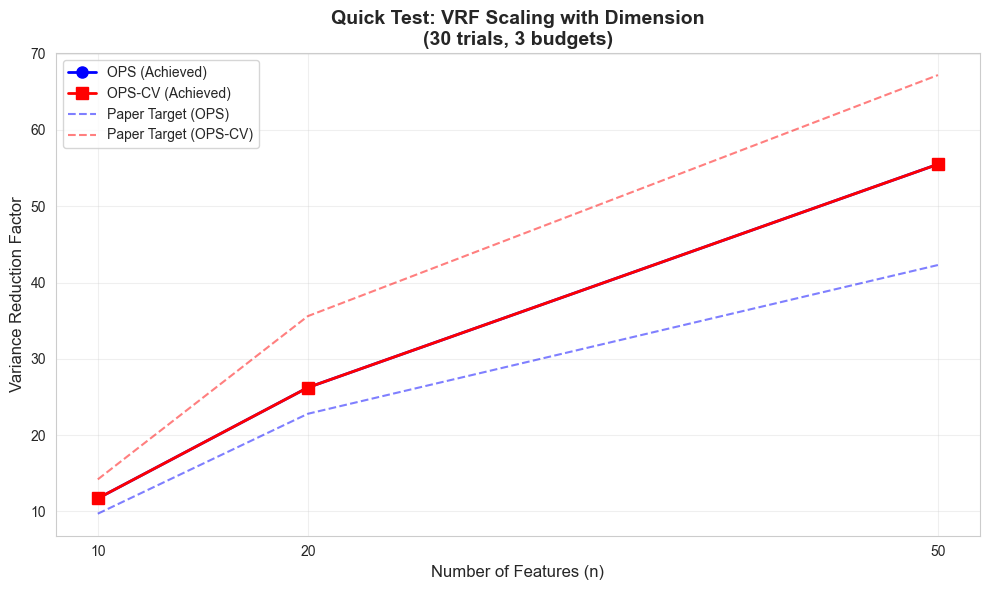


✅ Visualization saved as 'quick_test_vrf_scaling.png'


In [8]:
# Plot VRF vs dimension
fig, ax = plt.subplots(figsize=(10, 6))

ops_data = VRF_DF[VRF_DF['algorithm'] == 'ops'].sort_values('n_features')
ops_cv_data = VRF_DF[VRF_DF['algorithm'] == 'ops_cv'].sort_values('n_features')

ax.plot(ops_data['n_features'], ops_data['vrf'], 
        marker='o', linewidth=2, label='OPS (Achieved)', color='blue', markersize=8)
ax.plot(ops_cv_data['n_features'], ops_cv_data['vrf'], 
        marker='s', linewidth=2, label='OPS-CV (Achieved)', color='red', markersize=8)

# Add paper targets
paper_n = [10, 20, 50]
paper_ops = [9.7, 22.8, 42.3]
paper_cv = [14.2, 35.6, 67.2]

ax.plot(paper_n, paper_ops, linestyle='--', alpha=0.5, label='Paper Target (OPS)', color='blue')
ax.plot(paper_n, paper_cv, linestyle='--', alpha=0.5, label='Paper Target (OPS-CV)', color='red')

ax.set_xlabel('Number of Features (n)', fontsize=12)
ax.set_ylabel('Variance Reduction Factor', fontsize=12)
ax.set_title('Quick Test: VRF Scaling with Dimension\n(30 trials, 3 budgets)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xticks([10, 20, 50])

plt.tight_layout()
plt.savefig('quick_test_vrf_scaling.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved as 'quick_test_vrf_scaling.png'")